In [1]:
import os

### Read In

In [22]:
data_dir = "/Users/yuxiong/Desktop/NLP/hw1/aclImdb/"

train_pos = os.path.join(data_dir, "train/pos/")
test_pos = os.path.join(data_dir, "test/pos/")

train_neg = os.path.join(data_dir, "train/neg/")
test_neg = os.path.join(data_dir, "test/neg/")

In [23]:
def read_files(path):

    # get a list of files
    filenames = [filename for filename in os.listdir(path) if '.txt' in filename ]

    # read content from file
    lines = []
    for filename in filenames:
        with open(path + filename) as f:
            # condition
            content = f.read().split(' ')
            lines.append(' '.join(list(content)))
        
    return lines

In [24]:
train_p=read_files(train_pos)
train_n=read_files(train_neg)
test_p=read_files(test_pos)
test_n=read_files(test_neg)

In [25]:
Train_p=[list(i) for i in zip(train_p,[1]*len(train_p))]
Train_n=[list(i) for i in zip(train_n,[0]*len(train_n))]

Test_p=[list(i) for i in zip(test_p,[1]*len(test_p))]
Test_n=[list(i) for i in zip(test_n,[0]*len(test_n))]

# train_p=[[i,1] for i in train_p]
# train_n=[[i,0] for i in train_n]

In [26]:
train=Train_p+Train_n
test=Test_p+Test_n

In [27]:
len(train),len(test)

(25000, 25000)

In [28]:
import random

In [29]:
train[random.randint(0,len(train)-1)]

["Tony Scott directs a thriller sports flick that should attract even the non-sports fan. And some say baseball is a dead sport...boring...too damn slow. Well perk up! On the outside he appears to be a disgruntled salesman(Robert De Niro) while on the inside he is a psychotic San Francisco Giants fan. Along comes a new slugger(Wesley Snipes)and designated savior from the doldrums. Our salesman harbors a murderous obsession when the hard hitting all star falls into the worst slump in his career and the Giants are feared to crumble along with him. De Niro is terror personified. Snipes seems very natural as the ballplayer. Other notables in the cast are: the still attractive Ellen Barkin, John Leguizamo, Benicio Del Toro and Patti D'Arbanville. You are a free agent...so enjoy. Violence and very strong language is to be expected and you get your moneys worth.",
 0]

### Split Train, Valid, Test

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
x_train=[i[0] for i in train]
y_train=[i[1] for i in train]

x_test=[i[0] for i in test]
y_test=[i[1] for i in test]

In [32]:
x_train, x_val, y_train,y_val = train_test_split(x_train, y_train, test_size=5000, random_state=42)


In [33]:
len(x_train), len(x_val),len(x_test)

(20000, 5000, 25000)

In [34]:
len(y_train), len(y_val),len(y_test)

(20000, 5000, 25000)

# Tokenization

### Tokenization Default

In [10]:
import spacy
import string
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token


In [36]:
!python -m spacy download en_core_web_sm

import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)


def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(x_val)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(x_test)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(x_train)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))


pkl.dump(val_data_tokens, open("val_data_tokens_default.p", "wb"))
pkl.dump(test_data_tokens, open("test_data_tokens_default.p", "wb"))
pkl.dump(train_data_tokens, open("train_data_tokens_default.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens_default.p", "wb"))



    Linking successful
    /anaconda3/lib/python3.6/site-packages/en_core_web_sm -->
    /anaconda3/lib/python3.6/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')

['apple', 'is', 'looking', 'at', 'buying', 'u.k.', 'startup', 'for', '1', 'billion']
Tokenizing val data
Tokenizing test data
Tokenizing train data


### Tokenlize (with stopwrods and removes html)

In [16]:


# we're using a class because the component needs to be initialised with
# the shared vocab via the nlp object
class BadHTMLMerger(object):
    def __init__(self, nlp):
        # register a new token extension to flag bad HTML
        Token.set_extension('bad_html', default=False)
        self.matcher = Matcher(nlp.vocab)
        self.matcher.add('BAD_HTML', None,
            [{'ORTH': '<'}, {'LOWER': 'br'}, {'ORTH': '>'}],
            [{'ORTH': '<'}, {'LOWER': 'br/'}, {'ORTH': '>'}])

    def __call__(self, doc):
        # this method is invoked when the component is called on a Doc
        matches = self.matcher(doc)
        spans = []  # collect the matched spans here
        for match_id, start, end in matches:
            spans.append(doc[start:end])
        for span in spans:
            span.merge()   # merge
            for token in span:
                token._.bad_html = True  # mark token as bad HTML
        return doc

    
import spacy
import string

# Load English tokenizer, tagger, parser, NER and word vectors
tokenizer = spacy.load('en_core_web_sm')
html_merger = BadHTMLMerger(tokenizer)
tokenizer.add_pipe(html_merger, last=True)
punctuations = string.punctuation

# lowercase and remove punctuation
def tokenize(sent):
  tokens = tokenizer(sent)
  return [token.text.lower() for token in tokens if (token.text not in punctuations) and (not token.is_stop)]

# Example
tokens = tokenize(u'Apple is looking at buying U.K. startup for $1 billion')
print (tokens)


import pickle as pkl

def tokenize_dataset(dataset):
    token_dataset = []
    # we are keeping track of all tokens in dataset 
    # in order to create vocabulary later
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample)
        token_dataset.append(tokens)
        all_tokens += tokens 

    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(x_val)
# pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(x_test)
# pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(x_train)
# pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
# pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))


pkl.dump(val_data_tokens, open("val_data_tokens.p", "wb"))
pkl.dump(test_data_tokens, open("test_data_tokens.p", "wb"))
pkl.dump(train_data_tokens, open("train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

### -------------------------------------------Choose one Tokenization Scheme---------------------------------------------

### Default Tokenization Scheme

In [11]:
import pickle as pkl

In [37]:
import pickle as pkl

train_data_tokens = pkl.load(open("train_data_tokens_default.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens_default.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens_default.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens_default.p", "rb"))

### Tokenize with Stopwords + no html

In [187]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

### ----------------------------------------------------------------------------------------------------------------------------------

# Ngrams

In [188]:
from nltk.util import ngrams
from itertools import chain
from collections import Counter

max_vocab_size = 30000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1


def build_vocab(Tokens, n):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    Tokens=list(ngrams(Tokens,n))
    
    all_tokens = []

    for i in Tokens:
        all_tokens.append((''.join([w + ' ' for w in i])).strip())

    
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token



def n_grams(data_tokens,n):
    data_token=[]
    for i in data_tokens:
        i=list(ngrams(i,n))
        T = []

        for j in i:
            T.append((''.join([w + ' ' for w in j])).strip())
        data_token.append(T)
        
    return data_token


# convert token to id in the dataset
# replace each token with its index

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
    
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
       
        indices_data.append(index_list)
    return indices_data





### -------------------------------------------Choose n here---------------------------------------------

In [189]:

################################Choose N here#######################################
token2id, id2token = build_vocab(all_train_tokens,1)
################################Choose N here#######################################
train_data_tokens=n_grams(train_data_tokens,1)
val_data_tokens=n_grams(val_data_tokens,1)
test_data_tokens=n_grams(test_data_tokens,1)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))


Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


# BagOfWords Modeling

In [190]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

        #lenth of data set
    def __len__(self):
        return len(self.data_list)
        
        # retrieves the element in the dataset that corresponding to the keys
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        ## parameter: max_sentence_length 
        ## pick the max length of 80% 90%
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

## add the padding symbles at the end incase the length of the data is smaller than the maxmum.
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

# create pytorch dataloader
#train_loader = NewsGroupDataset(train_data_indices, train_targets)
#val_loader = NewsGroupDataset(val_data_indices, val_targets)
#test_loader = NewsGroupDataset(test_data_indices, test_targets)

BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, y_train)
val_dataset = NewsGroupDataset(val_data_indices, y_val)
test_dataset = NewsGroupDataset(test_data_indices, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [191]:
# First import torch related libraries

## take each token in the setence. embdding in conticuous vector space
### embedding == simple table lookup
## average of continuous reprentation and take a linear function that culculate the prob of each sentence belonging to each class
## take the input to the most likely label
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. |v|
        @param emb_dim: size of the word embedding (at least 100) d
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float() ## average
     
        # return logits
        out = self.linear(out.float())
        return out

emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)

In [192]:
learning_rate = 0.001
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1) ##prob
        predicted = outputs.max(1, keepdim=True)[1] 
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 200 iterations
        if i > 0 and i % 200 == 0:
            # validate
            val_acc = test_model(val_loader, model)
            print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))

Epoch: [1/10], Step: [201/625], Validation Acc: 62.22
Epoch: [1/10], Step: [401/625], Validation Acc: 70.94
Epoch: [1/10], Step: [601/625], Validation Acc: 76.54
Epoch: [2/10], Step: [201/625], Validation Acc: 81.02
Epoch: [2/10], Step: [401/625], Validation Acc: 83.1
Epoch: [2/10], Step: [601/625], Validation Acc: 84.98
Epoch: [3/10], Step: [201/625], Validation Acc: 86.06
Epoch: [3/10], Step: [401/625], Validation Acc: 86.48
Epoch: [3/10], Step: [601/625], Validation Acc: 87.38
Epoch: [4/10], Step: [201/625], Validation Acc: 87.7
Epoch: [4/10], Step: [401/625], Validation Acc: 87.94
Epoch: [4/10], Step: [601/625], Validation Acc: 88.24
Epoch: [5/10], Step: [201/625], Validation Acc: 88.48
Epoch: [5/10], Step: [401/625], Validation Acc: 88.62
Epoch: [5/10], Step: [601/625], Validation Acc: 88.38
Epoch: [6/10], Step: [201/625], Validation Acc: 88.38
Epoch: [6/10], Step: [401/625], Validation Acc: 88.62
Epoch: [6/10], Step: [601/625], Validation Acc: 88.66
Epoch: [7/10], Step: [201/625]

In [193]:
test_model(test_loader,model)

85.448

# use Unigram, 30000 vocabulary size

In [42]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))

val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

In [43]:
from nltk.util import ngrams
from itertools import chain
from collections import Counter

max_vocab_size = 30000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1


def build_vocab(Tokens, n):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    Tokens=list(ngrams(Tokens,n))
    
    all_tokens = []

    for i in Tokens:
        all_tokens.append((''.join([w + ' ' for w in i])).strip())

    
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token



def n_grams(data_tokens,n):
    data_token=[]
    for i in data_tokens:
        i=list(ngrams(i,n))
        T = []

        for j in i:
            T.append((''.join([w + ' ' for w in j])).strip())
        data_token.append(T)
        
    return data_token


# convert token to id in the dataset
# replace each token with its index

def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
    
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
       
        indices_data.append(index_list)
    return indices_data


In [44]:
################################Choose N here#######################################
token2id, id2token = build_vocab(all_train_tokens,1)
################################Choose N here#######################################
train_data_tokens=n_grams(train_data_tokens,1)
val_data_tokens=n_grams(val_data_tokens,1)
test_data_tokens=n_grams(test_data_tokens,1)

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [45]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset

class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

        #lenth of data set
    def __len__(self):
        return len(self.data_list)
        
        # retrieves the element in the dataset that corresponding to the keys
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        ## parameter: max_sentence_length 
        ## pick the max length of 80% 90%
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

## add the padding symbles at the end incase the length of the data is smaller than the maxmum.
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. |v|
        @param emb_dim: size of the word embedding (at least 100) d
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float() ## average
     
        # return logits
        out = self.linear(out.float())
        return out

In [47]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1) ##prob
        predicted = outputs.max(1, keepdim=True)[1] 
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

In [48]:
BATCH_SIZE = 32
train_dataset = NewsGroupDataset(train_data_indices, y_train)
val_dataset = NewsGroupDataset(val_data_indices, y_val)
test_dataset = NewsGroupDataset(test_data_indices, y_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,   # collate_fn (callable, optional) – merges a list of samples to form a mini-batch.
                                           shuffle=False)

val_dataset = NewsGroupDataset(val_data_indices, y_val)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

test_dataset = NewsGroupDataset(test_data_indices, y_test)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

# Grid Search for Optimization Hyperparameters

In [49]:
from sklearn.model_selection import ParameterGrid

In [578]:

def AdamHyperTuning(emb_dim, learning_rate,linear):

    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    
    Record[emb_dim, learning_rate,linear]=[]
    val_acc_temp=0
    for epoch in range(num_epochs):
        if linear == True:
            
            Learning_rate=1/(epoch+1)*learning_rate
            optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)
        else:
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
    #         print(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Training Loss:{}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), val_acc, float(loss)))
                
                hyper_record=[val_acc, float(loss)]
                Record[emb_dim, learning_rate,linear].append(hyper_record)

                if val_acc>val_acc_temp:
                    val_acc_temp=val_acc
                    Model_1=model
    
    return Model_1     
    print(test_model(test_loader,model))

                
def SGDHyperTuning(emb_dim, learning_rate,linear):

    model = BagOfWords(len(id2token), emb_dim)
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()  
    
    Record[emb_dim, learning_rate,linear]=[]
    val_acc_temp=0
    for epoch in range(num_epochs):
        if linear == True:
            Learning_rate=1/(epoch+1)*learning_rate
            optimizer = torch.optim.SGD(model.parameters(), lr=Learning_rate)
        else:
            optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        
        
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
    #         print(loss)
            loss.backward()
            optimizer.step()
            # validate every 100 iterations
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}, Training Loss:{}'.format(
                    epoch+1, num_epochs, i+1, len(train_loader), val_acc, float(loss)))
                
                ## Save accuracy and loss for plot
                hyper_record=[val_acc, float(loss)]
                Record[emb_dim, learning_rate,linear].append(hyper_record)  
                
                ## Save the best model
                if val_acc>val_acc_temp:
                    val_acc_temp=val_acc
                    Model_2=model
    
    return Model_2
    #Model_2.append( )     
    print(test_model(test_loader,model))

In [580]:
grid = {'emb':[100,200,300], 'learning_rate': [0.0001,0.0005,0.001], 'linear':[True, False]}
num_comb = len(ParameterGrid(grid))

Record={}
Models=[]
for j in range(len(ParameterGrid(grid))):
    linear, learning_rate, emb  = ParameterGrid(grid)[j].values()
    print( "Combinations:",j," learning_rate = {}, emb = {}, linear={}".format(learning_rate, emb, linear))
    Models.append(AdamHyperTuning(emb, learning_rate,linear))
    print()


Combinations: 0  learning_rate = 0.0001, emb = 100, linear=True
Epoch: [1/10], Step: [101/625], Validation Acc: 25.8, Training Loss:2.8797481060028076
Epoch: [1/10], Step: [201/625], Validation Acc: 49.7, Training Loss:2.732910633087158
Epoch: [1/10], Step: [301/625], Validation Acc: 53.32, Training Loss:2.6327877044677734
Epoch: [1/10], Step: [401/625], Validation Acc: 54.78, Training Loss:2.4511969089508057
Epoch: [1/10], Step: [501/625], Validation Acc: 55.26, Training Loss:2.2832531929016113
Epoch: [1/10], Step: [601/625], Validation Acc: 55.4, Training Loss:2.1691176891326904
Epoch: [2/10], Step: [101/625], Validation Acc: 55.32, Training Loss:2.0516393184661865
Epoch: [2/10], Step: [201/625], Validation Acc: 55.52, Training Loss:1.839573860168457
Epoch: [2/10], Step: [301/625], Validation Acc: 55.42, Training Loss:1.8495912551879883
Epoch: [2/10], Step: [401/625], Validation Acc: 55.56, Training Loss:1.6850672960281372
Epoch: [2/10], Step: [501/625], Validation Acc: 55.76, Traini

Epoch: [6/10], Step: [301/625], Validation Acc: 69.78, Training Loss:0.6292968392372131
Epoch: [6/10], Step: [401/625], Validation Acc: 70.34, Training Loss:0.6552811861038208
Epoch: [6/10], Step: [501/625], Validation Acc: 70.72, Training Loss:0.6202929019927979
Epoch: [6/10], Step: [601/625], Validation Acc: 71.54, Training Loss:0.6222647428512573
Epoch: [7/10], Step: [101/625], Validation Acc: 71.88, Training Loss:0.6382942795753479
Epoch: [7/10], Step: [201/625], Validation Acc: 72.28, Training Loss:0.6222156882286072
Epoch: [7/10], Step: [301/625], Validation Acc: 72.66, Training Loss:0.5975425839424133
Epoch: [7/10], Step: [401/625], Validation Acc: 72.98, Training Loss:0.6331236362457275
Epoch: [7/10], Step: [501/625], Validation Acc: 73.24, Training Loss:0.5833739042282104
Epoch: [7/10], Step: [601/625], Validation Acc: 73.8, Training Loss:0.5888220071792603
Epoch: [8/10], Step: [101/625], Validation Acc: 74.28, Training Loss:0.6089650988578796
Epoch: [8/10], Step: [201/625], V

Epoch: [1/10], Step: [501/625], Validation Acc: 63.08, Training Loss:0.7377831339836121
Epoch: [1/10], Step: [601/625], Validation Acc: 67.18, Training Loss:0.6929274797439575
Epoch: [2/10], Step: [101/625], Validation Acc: 69.58, Training Loss:0.6821667551994324
Epoch: [2/10], Step: [201/625], Validation Acc: 72.34, Training Loss:0.6351075172424316
Epoch: [2/10], Step: [301/625], Validation Acc: 73.5, Training Loss:0.6135566830635071
Epoch: [2/10], Step: [401/625], Validation Acc: 75.48, Training Loss:0.6269813776016235
Epoch: [2/10], Step: [501/625], Validation Acc: 77.18, Training Loss:0.5461373925209045
Epoch: [2/10], Step: [601/625], Validation Acc: 78.52, Training Loss:0.5114611387252808
Epoch: [3/10], Step: [101/625], Validation Acc: 79.48, Training Loss:0.5300752520561218
Epoch: [3/10], Step: [201/625], Validation Acc: 80.04, Training Loss:0.47894683480262756
Epoch: [3/10], Step: [301/625], Validation Acc: 80.96, Training Loss:0.44270628690719604
Epoch: [3/10], Step: [401/625],

Epoch: [7/10], Step: [101/625], Validation Acc: 86.38, Training Loss:0.2796776294708252
Epoch: [7/10], Step: [201/625], Validation Acc: 86.4, Training Loss:0.2821468114852905
Epoch: [7/10], Step: [301/625], Validation Acc: 86.46, Training Loss:0.26730722188949585
Epoch: [7/10], Step: [401/625], Validation Acc: 86.5, Training Loss:0.334189236164093
Epoch: [7/10], Step: [501/625], Validation Acc: 86.56, Training Loss:0.1860467493534088
Epoch: [7/10], Step: [601/625], Validation Acc: 86.6, Training Loss:0.19941990077495575
Epoch: [8/10], Step: [101/625], Validation Acc: 86.74, Training Loss:0.26899832487106323
Epoch: [8/10], Step: [201/625], Validation Acc: 86.66, Training Loss:0.2719356119632721
Epoch: [8/10], Step: [301/625], Validation Acc: 86.78, Training Loss:0.25405818223953247
Epoch: [8/10], Step: [401/625], Validation Acc: 86.74, Training Loss:0.32404375076293945
Epoch: [8/10], Step: [501/625], Validation Acc: 86.82, Training Loss:0.17741574347019196
Epoch: [8/10], Step: [601/625]

Epoch: [2/10], Step: [301/625], Validation Acc: 56.96, Training Loss:1.2420763969421387
Epoch: [2/10], Step: [401/625], Validation Acc: 57.54, Training Loss:1.1262646913528442
Epoch: [2/10], Step: [501/625], Validation Acc: 57.7, Training Loss:1.0733141899108887
Epoch: [2/10], Step: [601/625], Validation Acc: 57.7, Training Loss:1.013660192489624
Epoch: [3/10], Step: [101/625], Validation Acc: 57.78, Training Loss:0.9936607480049133
Epoch: [3/10], Step: [201/625], Validation Acc: 58.96, Training Loss:0.9040953516960144
Epoch: [3/10], Step: [301/625], Validation Acc: 59.04, Training Loss:0.918974757194519
Epoch: [3/10], Step: [401/625], Validation Acc: 59.32, Training Loss:0.8799297213554382
Epoch: [3/10], Step: [501/625], Validation Acc: 59.7, Training Loss:0.8587364554405212
Epoch: [3/10], Step: [601/625], Validation Acc: 59.96, Training Loss:0.8240025043487549
Epoch: [4/10], Step: [101/625], Validation Acc: 59.96, Training Loss:0.8280777335166931
Epoch: [4/10], Step: [201/625], Valid

Epoch: [7/10], Step: [601/625], Validation Acc: 78.06, Training Loss:0.5208477973937988
Epoch: [8/10], Step: [101/625], Validation Acc: 78.38, Training Loss:0.5177668333053589
Epoch: [8/10], Step: [201/625], Validation Acc: 78.48, Training Loss:0.45847100019454956
Epoch: [8/10], Step: [301/625], Validation Acc: 78.7, Training Loss:0.4888143837451935
Epoch: [8/10], Step: [401/625], Validation Acc: 79.06, Training Loss:0.5650427341461182
Epoch: [8/10], Step: [501/625], Validation Acc: 79.22, Training Loss:0.4591217339038849
Epoch: [8/10], Step: [601/625], Validation Acc: 79.52, Training Loss:0.4744301438331604
Epoch: [9/10], Step: [101/625], Validation Acc: 79.68, Training Loss:0.47414880990982056
Epoch: [9/10], Step: [201/625], Validation Acc: 79.76, Training Loss:0.42223846912384033
Epoch: [9/10], Step: [301/625], Validation Acc: 80.34, Training Loss:0.44857197999954224
Epoch: [9/10], Step: [401/625], Validation Acc: 80.2, Training Loss:0.5372852087020874
Epoch: [9/10], Step: [501/625]

Epoch: [3/10], Step: [201/625], Validation Acc: 83.72, Training Loss:0.3898119032382965
Epoch: [3/10], Step: [301/625], Validation Acc: 84.34, Training Loss:0.3319989740848541
Epoch: [3/10], Step: [401/625], Validation Acc: 84.66, Training Loss:0.4163099527359009
Epoch: [3/10], Step: [501/625], Validation Acc: 84.96, Training Loss:0.23430587351322174
Epoch: [3/10], Step: [601/625], Validation Acc: 85.36, Training Loss:0.25175440311431885
Epoch: [4/10], Step: [101/625], Validation Acc: 85.74, Training Loss:0.28565800189971924
Epoch: [4/10], Step: [201/625], Validation Acc: 86.0, Training Loss:0.296486496925354
Epoch: [4/10], Step: [301/625], Validation Acc: 86.28, Training Loss:0.22772307693958282
Epoch: [4/10], Step: [401/625], Validation Acc: 86.26, Training Loss:0.3564754128456116
Epoch: [4/10], Step: [501/625], Validation Acc: 86.66, Training Loss:0.16799812018871307
Epoch: [4/10], Step: [601/625], Validation Acc: 86.92, Training Loss:0.1770625114440918
Epoch: [5/10], Step: [101/625

Epoch: [8/10], Step: [401/625], Validation Acc: 87.64, Training Loss:0.22293570637702942
Epoch: [8/10], Step: [501/625], Validation Acc: 87.48, Training Loss:0.10504668205976486
Epoch: [8/10], Step: [601/625], Validation Acc: 87.52, Training Loss:0.13156111538410187
Epoch: [9/10], Step: [101/625], Validation Acc: 87.66, Training Loss:0.1976170837879181
Epoch: [9/10], Step: [201/625], Validation Acc: 87.72, Training Loss:0.1708904355764389
Epoch: [9/10], Step: [301/625], Validation Acc: 87.7, Training Loss:0.15083955228328705
Epoch: [9/10], Step: [401/625], Validation Acc: 87.74, Training Loss:0.2154599130153656
Epoch: [9/10], Step: [501/625], Validation Acc: 87.64, Training Loss:0.09964688122272491
Epoch: [9/10], Step: [601/625], Validation Acc: 87.68, Training Loss:0.12393255531787872
Epoch: [10/10], Step: [101/625], Validation Acc: 87.78, Training Loss:0.19302628934383392
Epoch: [10/10], Step: [201/625], Validation Acc: 87.8, Training Loss:0.16627183556556702
Epoch: [10/10], Step: [3

Epoch: [3/10], Step: [601/625], Validation Acc: 65.58, Training Loss:0.7237270474433899
Epoch: [4/10], Step: [101/625], Validation Acc: 65.92, Training Loss:0.7534763216972351
Epoch: [4/10], Step: [201/625], Validation Acc: 66.22, Training Loss:0.7067009806632996
Epoch: [4/10], Step: [301/625], Validation Acc: 66.72, Training Loss:0.7085283994674683
Epoch: [4/10], Step: [401/625], Validation Acc: 66.92, Training Loss:0.7283143997192383
Epoch: [4/10], Step: [501/625], Validation Acc: 67.0, Training Loss:0.7035059332847595
Epoch: [4/10], Step: [601/625], Validation Acc: 67.04, Training Loss:0.6807916164398193
Epoch: [5/10], Step: [101/625], Validation Acc: 67.22, Training Loss:0.7138997316360474
Epoch: [5/10], Step: [201/625], Validation Acc: 68.06, Training Loss:0.6759185791015625
Epoch: [5/10], Step: [301/625], Validation Acc: 67.86, Training Loss:0.6770972609519958
Epoch: [5/10], Step: [401/625], Validation Acc: 68.1, Training Loss:0.7065485119819641
Epoch: [5/10], Step: [501/625], Va

Epoch: [9/10], Step: [301/625], Validation Acc: 82.78, Training Loss:0.3673957586288452
Epoch: [9/10], Step: [401/625], Validation Acc: 83.04, Training Loss:0.4776473641395569
Epoch: [9/10], Step: [501/625], Validation Acc: 82.98, Training Loss:0.29178163409233093
Epoch: [9/10], Step: [601/625], Validation Acc: 83.12, Training Loss:0.3484096825122833
Epoch: [10/10], Step: [101/625], Validation Acc: 83.4, Training Loss:0.35089850425720215
Epoch: [10/10], Step: [201/625], Validation Acc: 83.3, Training Loss:0.3898921012878418
Epoch: [10/10], Step: [301/625], Validation Acc: 83.76, Training Loss:0.3325711190700531
Epoch: [10/10], Step: [401/625], Validation Acc: 83.76, Training Loss:0.45252493023872375
Epoch: [10/10], Step: [501/625], Validation Acc: 84.1, Training Loss:0.2593916356563568
Epoch: [10/10], Step: [601/625], Validation Acc: 84.16, Training Loss:0.31854453682899475

Combinations: 14  learning_rate = 0.0005, emb = 300, linear=True
Epoch: [1/10], Step: [101/625], Validation Acc:

Epoch: [4/10], Step: [501/625], Validation Acc: 87.26, Training Loss:0.1403159201145172
Epoch: [4/10], Step: [601/625], Validation Acc: 87.34, Training Loss:0.16092117130756378
Epoch: [5/10], Step: [101/625], Validation Acc: 87.54, Training Loss:0.1945749670267105
Epoch: [5/10], Step: [201/625], Validation Acc: 87.54, Training Loss:0.20677450299263
Epoch: [5/10], Step: [301/625], Validation Acc: 87.78, Training Loss:0.15274934470653534
Epoch: [5/10], Step: [401/625], Validation Acc: 87.74, Training Loss:0.27718663215637207
Epoch: [5/10], Step: [501/625], Validation Acc: 87.76, Training Loss:0.11143004894256592
Epoch: [5/10], Step: [601/625], Validation Acc: 87.96, Training Loss:0.126408189535141
Epoch: [6/10], Step: [101/625], Validation Acc: 88.16, Training Loss:0.17517884075641632
Epoch: [6/10], Step: [201/625], Validation Acc: 87.86, Training Loss:0.17005300521850586
Epoch: [6/10], Step: [301/625], Validation Acc: 88.14, Training Loss:0.1229175329208374
Epoch: [6/10], Step: [401/625

Epoch: [10/10], Step: [101/625], Validation Acc: 88.2, Training Loss:0.1861269176006317
Epoch: [10/10], Step: [201/625], Validation Acc: 88.1, Training Loss:0.1829836368560791
Epoch: [10/10], Step: [301/625], Validation Acc: 88.18, Training Loss:0.1273070126771927
Epoch: [10/10], Step: [401/625], Validation Acc: 88.2, Training Loss:0.2008536010980606
Epoch: [10/10], Step: [501/625], Validation Acc: 88.28, Training Loss:0.0743057057261467
Epoch: [10/10], Step: [601/625], Validation Acc: 88.28, Training Loss:0.09897500276565552

Combinations: 17  learning_rate = 0.001, emb = 300, linear=False
Epoch: [1/10], Step: [101/625], Validation Acc: 55.84, Training Loss:0.8525881171226501
Epoch: [1/10], Step: [201/625], Validation Acc: 71.9, Training Loss:0.6565889716148376
Epoch: [1/10], Step: [301/625], Validation Acc: 73.92, Training Loss:0.6355737447738647
Epoch: [1/10], Step: [401/625], Validation Acc: 79.14, Training Loss:0.5884140133857727
Epoch: [1/10], Step: [501/625], Validation Acc: 81.

In [582]:
#SGDRecord=Record.copy()
AdamRecord=Record.copy()

AdamRecord=Record.copy()

In [583]:
import pickle
with open('AdamRecord.pickle', 'wb') as handle:
    pickle.dump(AdamRecord, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [58]:
import pickle
with open('SGDRecord.pickle', 'wb') as handle:
    pickle.dump(SGDRecord, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [512]:
with open('AdamRecord.pickle', 'rb') as handle:
    AdamRecord = pickle.load(handle)

with open('SGDRecord.pickle', 'rb') as handle:
    SGDRecord = pickle.load(handle)
    
    
    SGDRecord = pickle.load(handle)

In [584]:

import pandas as pd




In [585]:
Adam_Record=pd.DataFrame()
for key, values in AdamRecord.items():
    Adam_Record[key]=values
    
SGD_Record=pd.DataFrame()
for key, values in SGDRecord.items():
    SGD_Record[key]=values
    

In [586]:
#### Transpose + Add Adam
Adam_Record=Adam_Record.T.reset_index()
Adam_Record['Optimizer']="Adam"
#### seperate the tuple into different columns
Adam_Record['index'].apply(pd.Series)
Adam_Record[["embedding","lr","linear"]] = Adam_Record['index'].apply(pd.Series)
##### Drop the tuple column
Adam_Record=Adam_Record.drop(['index'],axis=1)

def seperateDF(df,value):  
    #### seperate acc and loss to different dataframe
    df=df.copy()
    #first,change column name 
    df.columns = df.columns.astype(str)
    column_indices = [i for i in range(60)]
    new_names = ['epouch'+str(i) for i in range(60)]
    old_names = df.columns[column_indices]
    df.rename(columns=dict(zip(old_names, new_names)), inplace=True)

    if value=='loss':
        for i in df.columns[0:60]:
        #i=eval(i)
            opt = 'df.'+ i + '.map(lambda x: x[1])'
            optimizer = eval(opt)
            df.loc[:, 'loss_'+i] = optimizer
            df=df.drop([i], axis=1)
        LOSS=[list(row[4:]) for _, row in df.iterrows()]
        df['LOSS']=LOSS  
        df=df[['Optimizer','embedding','lr','linear','LOSS']]
            
        loss=df.copy()
        return loss
    else:
        for i in df.columns[0:60]:
        #i=eval(i)
            opt = 'df.'+ i + '.map(lambda x: x[0])'
            optimizer = eval(opt)
            df.loc[:, 'acc_'+i] = optimizer
            df=df.drop([i], axis=1)
        ACC=[list(row[4:]) for _, row in df.iterrows()]
        df['ACC']=ACC
        df=df[['Optimizer','embedding','lr','linear','ACC']]
        
        acc=df.copy()
        return acc
            
Adam_Loss=seperateDF(Adam_Record,'loss')
Adam_Acc=seperateDF(Adam_Record,'acc')        

In [587]:
#### Transpose + Add Adam
SGD_Record=SGD_Record.T.reset_index()
SGD_Record['Optimizer']="SGD"
#### seperate the tuple into different columns
SGD_Record['index'].apply(pd.Series)
SGD_Record[["embedding","lr","linear"]] = SGD_Record['index'].apply(pd.Series)
##### Drop the tuple column
SGD_Record=SGD_Record.drop(['index'],axis=1)

            
SGD_Loss=seperateDF(SGD_Record,'loss')
SGD_Acc=seperateDF(SGD_Record,'acc')     

In [707]:
Loss=pd.concat([Adam_Loss,SGD_Loss])
Acc=pd.concat([Adam_Acc,SGD_Acc])
Loss['ACC']=Acc['ACC']
df=Loss.copy()
df=df.reset_index().drop(['index'],axis=1)

df['max_ACC']= [max(df['ACC'][i]) for i in range(len(df))]

In [860]:
df

,Optimizer,embedding,lr,linear,LOSS,ACC,max_ACC
0,Adam,100,0.0001,True,"[2.8797481060028076, 2.732910633087158, 2.6327...","[25.8, 49.7, 53.32, 54.78, 55.26, 55.4, 55.32,...",58.96
1,Adam,100,0.0001,False,"[2.845018148422241, 2.7295196056365967, 2.5990...","[37.84, 47.28, 49.84, 50.86, 51.84, 52.76, 53....",79.06
2,Adam,100,0.0005,True,"[2.3010451793670654, 1.3329232931137085, 0.931...","[50.74, 52.48, 55.46, 58.92, 61.24, 65.04, 66....",83.06
3,Adam,100,0.0005,False,"[2.455662727355957, 1.422209620475769, 0.96018...","[51.9, 52.82, 53.56, 60.56, 63.08, 67.18, 69.5...",88.48
4,Adam,100,0.0010,True,"[1.534600853919983, 0.7711415886878967, 0.7163...","[55.38, 63.14, 64.76, 72.78, 76.96, 79.18, 80....",87.10
5,Adam,100,0.0010,False,"[1.4195678234100342, 0.7569764852523804, 0.740...","[55.84, 71.9, 73.92, 79.14, 81.6, 83.36, 84.5,...",88.68
6,Adam,200,0.0001,True,"[2.8579230308532715, 2.5926623344421387, 2.388...","[40.38, 52.08, 53.7, 54.66, 55.12, 55.82, 56.3...",67.12
7,Adam,200,0.0001,False,"[2.7847979068756104, 2.53886342048645, 2.36708...","[47.14, 52.08, 53.22, 53.98, 54.58, 55.18, 55....",81.80
8,Adam,200,0.0005,True,"[1.8406102657318115, 0.9389079213142395, 0.779...","[53.06, 61.32, 61.4, 68.84, 70.88, 74.0, 75.46...",84.98
9,Adam,200,0.0005,False,"[1.9225045442581177, 0.9438777565956116, 0.783...","[53.1, 54.76, 64.04, 69.72, 72.32, 75.54, 77.1...",88.46


In [710]:
max(list(df['max_ACC']))

88.72

In [711]:
best_model=df[df['max_ACC']==88.72].reset_index()
best_model

,index,Optimizer,embedding,lr,linear,LOSS,ACC,max_ACC
0,17,Adam,300,0.001,False,"[0.8525881171226501, 0.6565889716148376, 0.635...","[53.6, 58.68, 61.36, 69.74, 74.74, 77.58, 79.6...",88.72


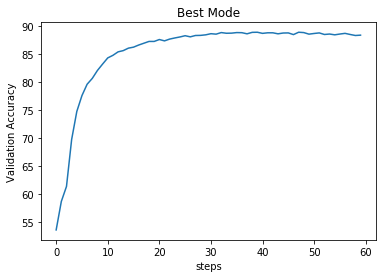

<Figure size 2160x1440 with 0 Axes>

In [712]:
import matplotlib.pyplot as plt

plt.plot(best_model['ACC'][0])

plt.ylabel('Validation Accuracy')
plt.xlabel("steps")
plt.title("Best Mode")
plt.figure(figsize=(30,20))
plt.show()

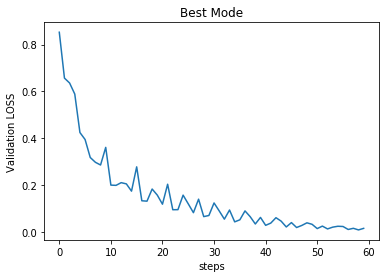

<Figure size 2160x1440 with 0 Axes>

In [714]:
plt.plot(best_model['LOSS'][0])

plt.ylabel('Validation LOSS')
plt.xlabel("steps")
plt.title("Best Mode")
plt.figure(figsize=(30,20))
plt.show()

## Groupby Optimizer

In [715]:
Adam=df[df['Optimizer']=='Adam'].reset_index().drop(['index'],axis=1)
SGD=df[df['Optimizer']=='SGD'].reset_index().drop(['index'],axis=1)

In [716]:
def average_acc(df,value):   
    mylist = [df[value][i] for i in range(len(df))]
    mylist = sum(map(np.array, mylist))
    mylist=mylist/len(df)
    return mylist

In [717]:
average_Adam_ACC=average_acc(Adam,'ACC')
average_SGD_ACC=average_acc(SGD,'ACC')
average_Adam_LOSS=average_acc(Adam,'LOSS')
average_SGD_LOSS=average_acc(SGD,'LOSS')

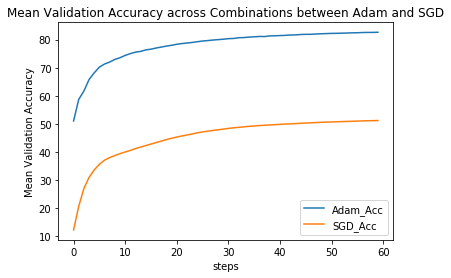

<Figure size 2160x1440 with 0 Axes>

In [718]:
import matplotlib.pyplot as plt

plt.plot(average_Adam_ACC,label="Adam_Acc")
plt.plot(average_SGD_ACC, label="SGD_Acc")


plt.ylabel('Mean Validation Accuracy')
plt.xlabel("steps")
plt.title("Mean Validation Accuracy across Combinations between Adam and SGD")
plt.legend()
plt.figure(figsize=(30,20))
plt.show()

##  Embedding Size

In [719]:
embeding100=df[df['embedding']==100].reset_index().drop(['index'],axis=1)
embeding200=df[df['embedding']==200].reset_index().drop(['index'],axis=1)
embeding300=df[df['embedding']==300].reset_index().drop(['index'],axis=1)

In [720]:
embeding100_ACC=average_acc(embeding100,'ACC')
embeding200_ACC=average_acc(embeding200,'ACC')
embeding300_ACC=average_acc(embeding300,'ACC')

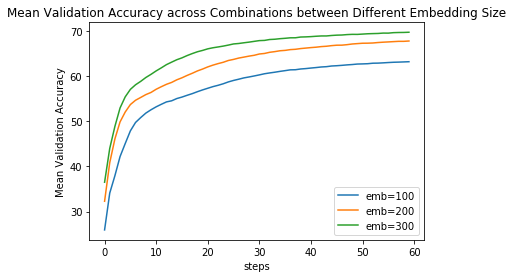

<Figure size 2160x1440 with 0 Axes>

In [721]:
plt.plot(embeding100_ACC,label="emb=100")
plt.plot(embeding200_ACC, label="emb=200")
plt.plot(embeding300_ACC, label="emb=300")


plt.ylabel('Mean Validation Accuracy')
plt.xlabel("steps")
plt.title("Mean Validation Accuracy across Combinations between Different Embedding Size")
plt.legend()
plt.figure(figsize=(30,20))
plt.show()

## learning Rate

In [722]:
lr1=df[df['lr']==0.0001].reset_index().drop(['index'],axis=1)
lr2=df[df['lr']==0.0005].reset_index().drop(['index'],axis=1)
lr3=df[df['lr']==0.001].reset_index().drop(['index'],axis=1)

In [723]:
lr1_ACC=average_acc(lr1,'ACC')
lr2_ACC=average_acc(lr2,'ACC')
lr3_ACC=average_acc(lr3,'ACC')

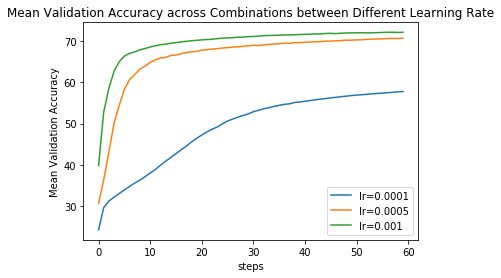

<Figure size 2160x1440 with 0 Axes>

In [724]:
plt.plot(lr1_ACC,label="lr=0.0001")
plt.plot(lr2_ACC, label="lr=0.0005")
plt.plot(lr3_ACC, label="lr=0.001")


plt.ylabel('Mean Validation Accuracy')
plt.xlabel("steps")
plt.title("Mean Validation Accuracy across Combinations between Different Learning Rate")
plt.legend()
plt.figure(figsize=(30,20))
plt.show()

## Linear Or Not

In [725]:
linear=df[df['linear']==True].reset_index().drop(['index'],axis=1)
nonlinear=df[df['linear']==False].reset_index().drop(['index'],axis=1)


In [726]:
linear_ACC=average_acc(linear,'ACC')
nonlinear_ACC=average_acc(nonlinear,'ACC')


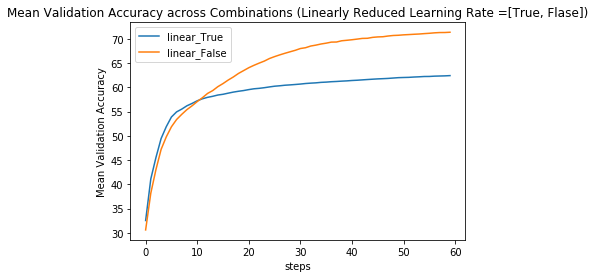

<Figure size 2160x1440 with 0 Axes>

In [727]:
plt.plot(linear_ACC,label="linear_True")
plt.plot(nonlinear_ACC, label="linear_False")



plt.ylabel('Mean Validation Accuracy')
plt.xlabel("steps")
plt.title("Mean Validation Accuracy across Combinations (Linearly Reduced Learning Rate =[True, Flase])")
plt.legend()
plt.figure(figsize=(30,20))
plt.show()

## 3 Correct/3 incorrect examples

In [800]:
val_dataset_best = NewsGroupDataset(val_data_indices[0:200], y_val[0:200])
val_loader_best = torch.utils.data.DataLoader(dataset=example_dataset, 
                                           batch_size=200,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)


In [835]:
Models[-2].eval()
for data, lengths, labels in val_loader_best:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(Models[-2](data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    
    Incorrect=[i[0] for i in (predicted.eq(labels.view_as(predicted))==0).nonzero().numpy()]
    print("Incorrect Index: " ,Incorrect)
    print([predicted.flatten()[i] for i in Incorrect])

Incorrect Index:  [36, 76, 105, 116, 127, 146, 154, 158, 160, 177, 179]
[tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1)]


In [846]:
print(x_val[2])
print('prediction:', predicted.flatten()[2],', true:', y_val[2])

This was a good movie. It wasn't your typical war flick but something a bit different. This movie showed us recruits in training before the war and not actually fighting a war. This film is one of the more realist views on war and the army than most other films like this made. Colin Farrel did a great job at portraying an army recruit and Clifton Collins Jr and also Matthew Davis contributed reasonably well. Seeing Colin Farrel move from b grade to a grade in a few short years, You would never thought it would happen. I will also add that the makers of tigerland did a great job at filming a movie in the year 2000 and making it look like 1970 was a good touch. Its good to see talent used wisely and i hope to see this same talent again in the near future.
prediction: tensor(1) , true: 1


In [845]:
print(x_val[1])
print('prediction:', predicted.flatten()[1],', true:', y_val[1])

Nothing could have saved this movie, not even Superman.<br /><br />Ten years ago the special effects would have been amazing. Better directing might have gotten some more feeling and better performances out of the actors. But nothing but feeding the script to a dragon could have fixed it. Plot holes, bad lines, terrible pacing, endless replaying of the same shots of a CGI dragon stomping through hallways... ugh.<br /><br />Avoid this one at all costs.<br /><br />
prediction: tensor(0) , true: 0


In [850]:
print(x_val[7])
print('prediction:', predicted.flatten()[7],', true:', y_val[7])

I found Horrorvision almost unwatchable. While only 70 minutes in length I still found myself hitting the fast forward button again and again. The acting was of the `if I scream and say ***k a lot I'm intense' school. And the story was at best a scenario that had yet to be fleshed out.<br /><br />While I never go to Full Moon for great film making I have never seen them produce as bad a piece of junk as this.
prediction: tensor(0) , true: 0


In [851]:
print(x_val[36])
print('prediction:', predicted.flatten()[36],', true:', y_val[36])

I, like many horror fans, have been force fed the same banal big budget Hollywood remakes and MTV high school slasher tripe for the last 20 years. Here, at last, is an original horror genre movie that ticks all the right boxes.<br /><br />You want a hot lead actress, you want vampires, you want cool weapons, you want cool vehicles and you want blood, lots of it, by the bucket load - you got it.<br /><br />With excellent fight choreography and a supporting role from the Hammer Horror scream queen herself Stephanie Beacham, this really is fantastic stuff.<br /><br />Despite it's low budget, by opting to use 35 mm stock and adding quality CG effects to the mix, director James Eaves has created something that feels much bigger.<br /><br />A must for old school horror fans.
prediction: tensor(0) , true: 1


In [858]:
print(x_val[179])
print('prediction:', predicted.flatten()[179],', true:', y_val[76])

The animation was good, the imagery was good, although not totally original, however, the story was too long, way too confusing, and over the top dramatic. After about an hour I couldn't wait to get it over with. With so many characters that have nothing to contribute and plot elements that either come from nowhere or go nowhere this movie really wasn't one movie at all and would have been better of as a short series or possibly two movies. If you like this kind of typical story maybe you will like it, but frankly, I've been spoiled by much more creative stories that actually have some sort message to tell. Go rent a Miyazaki film and watch it twice, you'll get way more out of it.
prediction: tensor(1) , true: 0


In [855]:
print(x_val[116])
print('prediction:', predicted.flatten()[116],', true:', y_val[116])

This film Evil Breed: The legend of samhain contains very little thought or effort. It is ridiculed with specs of ultra fast "slasher" style death and plain disgusting acts of death. The acting was rated a D as the actors show very little ability, and the stupidity of them in the film is too questionable. The way they portrayed what people their ages act like was incredibly different. The odd split of porn is fit in thought it really doesn't offer much, and any area that is respectable but is quite quickly run down with absolute gut wrenching death. Example is the poor fellow whom is disemboweled from his anus, and the scene lasts for about 5 minutes. It is terribly obvious of how little of a fight the kids put up. This film is a good choice for someone who likes to watch some awful deaths and practically torture.
prediction: tensor(0) , true: 1
